In [154]:
import pandas as pd
import numpy as np

### Training and testing data

In [155]:
#Path on my system to training data
train_path = "./../Datasets/Fall examples/Fall examples/Farseeing/Data/Train/"

In [156]:
#Read all training data files
from os import walk

data_for_fall=[]

for (dirpath, dirnames, filenames) in walk(train_path):
    
    for file in filenames:
        print(dirpath+file)
        data = pd.read_csv(dirpath+file)
        data.columns = ['Time','Rel_Time','Acc_X','Acc_Y','Acc_Z','Mg_X','Mg_Y','Mg_Z','Ang_X','Ang_Y','Ang_Z','Fall_indicator']
        data_for_fall.append(data)

./../Datasets/Fall examples/Fall examples/Farseeing/Data/Train/F_04835861-01-2013-10-16-13-19-35.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Train/F_17744725-01-2009-02-24-16-26-44.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Train/F_20983985-01-2013-05-16-16-16-00.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Train/F_23112025-01-2013-05-21-06-21-54.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Train/F_36551836-01-2013-05-21-17-39-57.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Train/F_38243026-05-2009-04-29-08-53-16.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Train/F_42990421-03a-2011-03-23-16-50-02.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Train/F_47451392-01-2014-01-22-22-42-34.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Train/F_63414187-01-2013-05-30-22-48-27.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Train/F_67458491-01-2013-11-07-12

In [157]:
#Print one file data in training
data_for_fall[0]

,Time,Rel_Time,Acc_X,Acc_Y,Acc_Z,Mg_X,Mg_Y,Mg_Z,Ang_X,Ang_Y,Ang_Z,Fall_indicator
0,184020.0,735520.0,2.0243,-8.4086,-2.95860,0,0,0,0,0,0,0
1,184020.0,735520.0,2.0243,-8.4086,-2.95860,0,0,0,0,0,0,0
2,184020.0,735520.0,2.0243,-8.4086,-2.95860,0,0,0,0,0,0,0
3,184020.0,735520.0,2.0243,-8.4086,-2.95860,0,0,0,0,0,0,0
4,184020.0,735520.0,2.0243,-8.4086,-2.95860,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
23995,185220.0,735520.0,8.7200,-1.8686,0.31143,0,0,0,0,0,0,0
23996,185220.0,735520.0,8.7200,-1.8686,0.31143,0,0,0,0,0,0,0
23997,185220.0,735520.0,8.7200,-1.8686,0.31143,0,0,0,0,0,0,0
23998,185220.0,735520.0,8.7200,-1.8686,0.31143,0,0,0,0,0,0,0


In [158]:
from scipy import stats
#Creates windows of size=20 and steps forward by 1
def create_dataset(X, Y, feature_size=20, step_size=1):
    window_X, window_Y = [], []
    for i in range(0, len(X) - feature_size, step_size):
        #Feature size=20 (size of window)
        window_data = X.iloc[i:(i + feature_size),:]
        #Get all the 20 labels
        labels = Y.iloc[i: i + feature_size]
        #Append for each 20 sized windows, each stepped forward by 1
        window_X.append(window_data)
        #Get the max value- If window contains the row that has fall data then window labelled as fall
        #The fall indicator can be any value >0 dependng on severity of fall
        window_Y.append(labels.max())
    return (window_X), np.array(window_Y).reshape(-1, 1)

In [159]:
def to_features(data):
    #Flattens the window data into one row
    #Will get 20 rows of 3 columns each = 60 data points in each row
    feature_columns = ['Acc_X','Acc_Y','Acc_Z']
    sensor_values = data[feature_columns].values 
    features = sensor_values.flatten()
    return features

In [160]:
from itertools import chain

#Get the training window data without overlap from other files
train_X_window = []
train_Y_window = []
#For each file in the 16 training files
for dataset in data_for_fall:
    #Get the fall event location in the file (only one file at a time)
    fall_event_loc = dataset[dataset['Fall_indicator']>0].index
    #Get 2 seconds of data around fall event
    for fall_loc in fall_event_loc:
        data_index_lists = []
        #2s of data - 1.5sec before fall, 0.5sec after fall
        data_index_lists.append(list(range(fall_loc-35,fall_loc+25)))
        #Get all the indices as a list    
        drop_arr = list(chain.from_iterable(data_index_lists))
        #Take only those indices that correspond to 2 seconds of data around fall event
        dataset_sample = dataset.iloc[drop_arr]
    

        #Create windowed data for the file
        train_each_X, train_each_Y = create_dataset(
            dataset_sample[['Acc_X', 'Acc_Y', 'Acc_Z']],
            dataset_sample[['Fall_indicator']],
            feature_size=20
        )
    
    
        #Adding only non-fall data from the files
        data_index_lists_non_fall=[]
        
        #1.2s of data - 10 seconds before fall, duration is 1.2 seconds
        data_index_lists_non_fall.append(list(range(fall_loc-600,fall_loc-570)))
        #Get all the indices as a list    
        non_fall_indices = list(chain.from_iterable(data_index_lists_non_fall))
        #Take only those indices that correspond to 2 seconds of data around fall event
        dataset_sample_non_fall = dataset.iloc[non_fall_indices]


        #Create windowed data for the file
        train_each_X_non_fall, train_each_Y_non_fall = create_dataset(
            dataset_sample_non_fall[['Acc_X', 'Acc_Y', 'Acc_Z']],
            dataset_sample_non_fall[['Fall_indicator']],
            feature_size=20
        )


        #Flatten the windowed data to get 60 features in a row
        train_each_X_non_fall_flat = np.stack([to_features(d) for d in train_each_X_non_fall])  

        #Flatten the windowed data to get 60 features in a row
        train_each_X_flat = np.stack([to_features(d) for d in train_each_X])
        #Append the data of each file
        train_X_window.append(train_each_X_flat)
        train_X_window.append(train_each_X_non_fall_flat)
        train_Y_window.append(train_each_Y)
        train_Y_window.append(train_each_Y_non_fall)

In [161]:
len(train_Y_window[1])

10

In [162]:
train_X_window[1].shape

(10, 60)

In [163]:
train_Y_window[1].shape

(10, 1)

In [164]:
train_X_window[1]

array([[-1.4014 ,  0.62286, 10.589  , -1.8686 ,  0.77857,  8.5643 ,
        -1.8686 ,  0.62286,  7.7857 , -1.5571 ,  1.2457 ,  7.1629 ,
        -0.77857,  1.2457 ,  7.3186 ,  1.8686 ,  1.2457 ,  7.7857 ,
         7.7857 , -1.09   ,  8.5643 ,  2.6471 ,  0.46714,  7.3186 ,
        -0.62286, -3.7371 , 14.481  , -1.5571 ,  7.3186 , 11.056  ,
        -2.0243 , -6.2286 , 10.433  , -3.27   , -1.5571 ,  9.81   ,
        -1.7129 ,  0.     ,  9.81   , -0.77857,  0.15571,  9.4986 ,
         0.15571, -0.93429,  9.4986 , -0.77857, -1.2457 ,  9.6543 ,
        -0.77857, -1.2457 ,  9.4986 , -0.77857, -0.77857,  9.6543 ,
        -0.46714, -0.15571,  9.81   , -1.8686 , -2.4914 ,  9.4986 ],
       [-1.8686 ,  0.77857,  8.5643 , -1.8686 ,  0.62286,  7.7857 ,
        -1.5571 ,  1.2457 ,  7.1629 , -0.77857,  1.2457 ,  7.3186 ,
         1.8686 ,  1.2457 ,  7.7857 ,  7.7857 , -1.09   ,  8.5643 ,
         2.6471 ,  0.46714,  7.3186 , -0.62286, -3.7371 , 14.481  ,
        -1.5571 ,  7.3186 , 11.056  , -2.0243 ,

In [165]:
for each_window in train_Y_window:
    print(len(each_window))

40
10
40
10
40
10
40
10
40
10
40
10
40
10
40
10
40
10
40
10
40
10
40
10
40
10
40
10
40
10
40
10
40
10


In [166]:
#Concatenate the windowed and flattened data of each file to form the training data
train_X = np.concatenate(train_X_window,axis = 0)
train_X

array([[-1.2457 ,  1.5571 ,  7.9414 , ..., -6.8514 ,  1.8686 ,  9.81   ],
       [-1.09   ,  1.7129 ,  7.3186 , ..., -2.6471 , -0.93429, 11.523  ],
       [-0.77857,  1.4014 ,  6.8514 , ...,  2.4914 , -3.1143 ,  8.5643 ],
       ...,
       [-1.6167 , -1.1119 , 10.218  , ..., -1.0158 ,  0.54891,  9.7729 ],
       [-1.5595 , -1.14   , 10.246  , ..., -1.0158 ,  0.46446,  9.8841 ],
       [-1.5309 , -1.1682 , 10.329  , ..., -0.90136,  0.43631, 10.051  ]])

In [167]:
train_X.shape

(850, 60)

In [168]:
#Reshape according to LSTM
# X_train = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
X_train = train_X.reshape(train_X.shape[0],20,3,1)

In [169]:
X_train.shape

(850, 20, 3, 1)

In [170]:
#Concatenate the fall indicator of each file to form the training labels
train_Y = np.concatenate(train_Y_window, axis=0)
train_Y

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
    

In [171]:
train_Y.shape

(850, 1)

In [172]:
train_Y

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
    

In [173]:
len(np.argwhere(train_Y > 0))

340

In [174]:
#Replace all labels of fall_indicator > 1 to 1
train_Y[train_Y > 1] = 1
len(np.argwhere(train_Y == 1))

340

In [175]:
len(np.argwhere(train_Y == 0))

510

In [176]:
test_path = "./../Datasets/Fall examples/Fall examples/Farseeing/Data/Test/"

In [177]:
from os import walk

# columns = ['Time','Acc_X','Acc_Y','Acc_Z','Fall_indicator']
# train_data = pd.DataFrame() #columns=columns)
data_for_fall_test=[]

for (dirpath, dirnames, filenames) in walk(test_path):
    
    for file in filenames:
        print(dirpath+file)
        data = pd.read_csv(dirpath+file)
        data.columns = ['Time','Rel_Time','Acc_X','Acc_Y','Acc_Z','Mg_X','Mg_Y','Mg_Z','Ang_X','Ang_Y','Ang_Z','Fall_indicator']
        data_for_fall_test.append(data)

./../Datasets/Fall examples/Fall examples/Farseeing/Data/Test/F_42990421-01-2011-02-19-15-59-57.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Test/F_42990421-02-2011-02-19-22-58-03.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Test/F_72858619-01-2008-06-26-07-27-49.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Test/F_72858619-02-2008-06-26-11-29-16.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Test/F_74827807-07-2009-02-16-19-10-44.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Test/F_96201346-03-2011-05-21-06-19-42.csv


In [178]:
#SAME TESTING SET
from itertools import chain


#Same process of split for testing data
test_X_window = []
test_Y_window = []
for dataset in data_for_fall_test:
    #Get the fall event location in the file (only one file at a time)
    fall_event_loc = dataset[dataset['Fall_indicator']>0].index
    data_index_lists = []
    #Get 2 seconds of data around fall event
    for fall_loc in fall_event_loc:
        #2s of data - 1.5sec before fall, 0.5sec after fall
        data_index_lists.append(list(range(fall_loc-40,fall_loc+20)))
    #Get all the indices as a list    
    drop_arr = list(chain.from_iterable(data_index_lists))
    #Take only those indices that correspond to 2 seconds of data around fall event
    dataset_sample = dataset.iloc[drop_arr]
    

    #Create windowed data for the file
    test_each_X, test_each_Y = create_dataset(
        dataset_sample[['Acc_X', 'Acc_Y', 'Acc_Z']],
        dataset_sample[['Fall_indicator']],
        feature_size=20
    )
    
    #Adding only non-fall data from the files
    data_index_lists_non_fall=[]
    for fall_loc in fall_event_loc:
        #2s of data - 10 seconds before fall, duration is 2 seconds
        data_index_lists_non_fall.append(list(range(fall_loc-600,fall_loc-560)))
    #Get all the indices as a list    
    drop_arr = list(chain.from_iterable(data_index_lists_non_fall))
    #Take only those indices that correspond to 2 seconds of data around fall event
    dataset_sample_non_fall = dataset.iloc[drop_arr]
    

    #Create windowed data for the file
    test_each_X_non_fall, test_each_Y_non_fall = create_dataset(
        dataset_sample_non_fall[['Acc_X', 'Acc_Y', 'Acc_Z']],
        dataset_sample_non_fall[['Fall_indicator']],
        feature_size=20
    )
    
    #Flatten the windowed data to get 60 features in a row
    test_each_X_flat = np.stack([to_features(d) for d in test_each_X])
    test_each_X_flat_non_fall = np.stack([to_features(d) for d in test_each_X_non_fall])
    
    #Append the data of each file
    test_X_window.append(test_each_X_flat)
    test_X_window.append(test_each_X_flat_non_fall)
    
    
    test_Y_window.append(test_each_Y)
    test_Y_window.append(test_each_Y_non_fall)
    
    

In [179]:
test_X = np.concatenate(test_X_window, axis = 0)
test_X

array([[-5.1077 , -0.60521,  7.354  , ..., -4.7643 , -0.54891,  6.4087 ],
       [-5.1077 , -0.57706,  7.6599 , ..., -4.564  , -0.49261,  6.3253 ],
       [-4.8502 , -0.40816,  7.2428 , ..., -4.3923 , -0.35187,  6.1307 ],
       ...,
       [-0.7869 , -1.6186 ,  9.7173 , ..., -0.87274, -1.5904 ,  9.7173 ],
       [-0.7869 , -1.6467 ,  9.6617 , ..., -0.87274, -1.6186 ,  9.7173 ],
       [-0.75828, -1.6749 ,  9.6061 , ..., -0.87274, -1.6186 ,  9.6617 ]])

In [180]:
test_X.shape

(360, 60)

In [181]:
# X_test = test_X.reshape(test_X.shape[0],test_X.shape[1],1)
X_test = test_X.reshape(test_X.shape[0],20,3,1)

In [182]:
test_Y = np.concatenate(test_Y_window, axis=0)
test_Y

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2],
       [2],
    

In [183]:
test_Y.shape

(360, 1)

In [184]:
len(np.argwhere(test_Y > 0))

114

In [185]:
#Replace all labels of fall_indicator > 1 to 1
test_Y[test_Y > 1] = 1

In [186]:
len(np.argwhere(test_Y == 1))

114

In [187]:
len(np.argwhere(test_Y == 0))

246

In [188]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(train_Y)
y_train = enc.transform(train_Y)

In [189]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

### ResNet identity block

In [190]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Conv2D,ReLU,add,MaxPool2D,AveragePooling2D,Flatten,Input
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization

In [191]:
def get_resnet_trial_model():
    def identity_block(X, filters, stride, kernel_size=(4,1)):
        out = Conv2D(filters, (1,1), stride, padding='same')(X)
        out = ReLU()(out)
        out = Conv2D(filters, kernel_size, stride, padding='same')(X)
        out = add([X, out])
        out = ReLU()(out)
#         out = MaxPool2D(pool_size=(2, 1))(out)
        return out

    kernels = 32
    stride = (1,1)
    
    inputs = Input([20,3,1])
    X = Conv2D(kernels, (2,1), stride)(inputs)
    print(X.shape)
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = MaxPool2D(pool_size=(2, 1))(X)
    print(X.shape)
    X = identity_block(X, kernels, stride)
    X = identity_block(X, kernels, stride)
    X = identity_block(X, kernels, stride)
    X = identity_block(X, kernels, stride)
    X = identity_block(X, kernels, stride)
    X = AveragePooling2D()(X)
    X = Flatten()(X)
    X = Dense(32, activation='relu')(X)
    X = Dense(32, activation='relu')(X)
    output = Dense(2, activation='softmax')(X)

    model = keras.Model(inputs=inputs, outputs=output)
    return model

In [192]:
# model = get_resnet_trial_model()

In [193]:
def get_resnet_trial_2_model():
    def identity_block(X, kernels, kernel_size=(4,3) ,stride=(1,1)):
        #Block 1
        out = Conv2D(kernels, (1,1), stride, padding='same')(X)
        out = BatchNormalization()(out)
        out = ReLU()(out)
        #Block 2
        out = Conv2D(kernels, kernel_size, stride, padding='same')(X)
        out = BatchNormalization()(out)
        out = ReLU()(out)
        #Block 3
        out = Conv2D(kernels, (1,1), stride, padding='same')(out)
        out = BatchNormalization()(out)
        #Add shortcut
        out = add([X, out])
        out = ReLU()(out)
        #out = MaxPool1D()(out)
        return out
    
    
    def conv_block(X, kernels, kernel_size=(4,3) ,stride=(1,1)):
        #Block 1
        out = Conv2D(kernels, (1,1), stride, padding='same')(X)
        out = BatchNormalization()(out)
        out = ReLU()(out)
        #Block 2
        out = Conv2D(kernels, kernel_size, stride, padding='same')(X)
        out = BatchNormalization()(out)
        out = ReLU()(out)
        #Block 3
        out = Conv2D(kernels, (1,1), stride, padding='same')(out)
        out = BatchNormalization()(out)
        
        #Define shortcut
        X_shortcut = Conv2D(kernels, (1,1), stride, padding='same')(X)
        X_shortcut = BatchNormalization()(X_shortcut)
        
        #Add shortcut
        out = add([out, X_shortcut])
        out = ReLU()(out)
        #out = MaxPool1D()(out)
        return out

#     kernels = [60,60,256]
    stride = (1,1)
    
    inputs = Input([20,3,1])
    #Layer 1
    X = Conv2D(60, (1,1), stride)(inputs)
    print(X.shape)
    X = BatchNormalization()(X)
    X = ReLU()(X)
#     X = MaxPool2D(pool_size=(1,1))(X)
    print(X.shape)
    
    #Layer 2
    X = conv_block(X, kernels = 64)
    X = identity_block(X, kernels = 64)
    X = identity_block(X, kernels = 64)
    
    
    #Layer 3
    X = conv_block(X, kernels = 128)
    X = identity_block(X, kernels = 128)
    X = identity_block(X, kernels = 128)
    X = identity_block(X, kernels = 128)
    
    
    #Layer 4
    X = conv_block(X, kernels = 256)
    X = identity_block(X, kernels = 256)
    X = identity_block(X, kernels = 256)
    X = identity_block(X, kernels = 256)
    X = identity_block(X, kernels = 256)
    X = identity_block(X, kernels = 256)
   
    
    #Layer 5
    X = conv_block(X, kernels = 512)
    X = identity_block(X, kernels = 512)
    X = identity_block(X, kernels = 512)
    
    X = AveragePooling2D()(X)
    print(X.shape)
    X = Flatten()(X)
    print(X.shape)
    output = Dense(2, activation='softmax')(X)

    model = keras.Model(inputs=inputs, outputs=output)
    return model

In [194]:
# model = get_resnet_trial_model()

In [195]:
model = get_resnet_trial_2_model()

(None, 20, 3, 60)
(None, 20, 3, 60)
(None, 10, 1, 512)
(None, 5120)


In [196]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [197]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 20, 3, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_159 (Conv2D)             (None, 20, 3, 60)    120         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_159 (BatchN (None, 20, 3, 60)    240         conv2d_159[0][0]                 
__________________________________________________________________________________________________
re_lu_147 (ReLU)                (None, 20, 3, 60)    0           batch_normalization_159[0][0]    
____________________________________________________________________________________________

In [198]:
# model.fit(X_train, to_categorical(Y_train), epochs=2, batch_size=128, verbose=2)


from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)

class_weight = {0: 0.87,
                1: 0.13}

history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2, validation_split=0.1, callbacks=[early_stop])



Epoch 1/100
24/24 - 25s - loss: 0.9767 - accuracy: 0.7791 - val_loss: 8.1196 - val_accuracy: 0.4706
Epoch 2/100
24/24 - 26s - loss: 0.4832 - accuracy: 0.8693 - val_loss: 1.7280 - val_accuracy: 0.8824
Epoch 3/100
24/24 - 43s - loss: 0.3349 - accuracy: 0.9033 - val_loss: 1.5142 - val_accuracy: 0.8824
Epoch 4/100
24/24 - 48s - loss: 0.3363 - accuracy: 0.9007 - val_loss: 1.1336 - val_accuracy: 0.9059
Epoch 5/100
24/24 - 50s - loss: 0.2839 - accuracy: 0.9059 - val_loss: 0.4810 - val_accuracy: 0.9176
Epoch 6/100
24/24 - 38s - loss: 0.2101 - accuracy: 0.9163 - val_loss: 0.4562 - val_accuracy: 0.9176
Epoch 7/100
24/24 - 28s - loss: 0.1756 - accuracy: 0.9320 - val_loss: 0.3323 - val_accuracy: 0.9529
Epoch 8/100
24/24 - 28s - loss: 0.1472 - accuracy: 0.9451 - val_loss: 0.3321 - val_accuracy: 0.9412
Epoch 9/100
24/24 - 29s - loss: 0.1197 - accuracy: 0.9608 - val_loss: 0.3193 - val_accuracy: 0.9412
Epoch 10/100
24/24 - 31s - loss: 0.0991 - accuracy: 0.9621 - val_loss: 1.1177 - val_accuracy: 0.8941

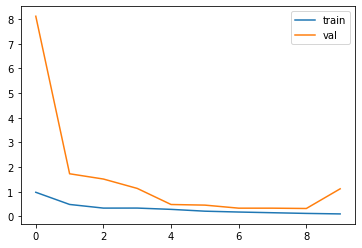

In [199]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

In [200]:
Y_pred = model.predict(X_test)

In [201]:
Y_pred.shape

(360, 2)

In [202]:
Y_pred_labels = np.argmax(Y_pred,axis=1)

In [203]:
Y_pred_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Accuracy:	90.55556%



The Classification Report is
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       246
           1       0.99      0.71      0.83       114

    accuracy                           0.91       360
   macro avg       0.93      0.85      0.88       360
weighted avg       0.92      0.91      0.90       360






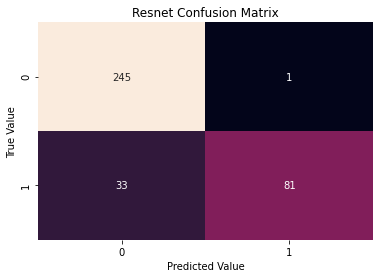

In [204]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

print('Accuracy:\t{:0.5f}%'.format(accuracy_score(test_Y,Y_pred_labels)*100))
print("\n\n")
print("The Classification Report is")
print(classification_report(test_Y, Y_pred_labels))
print("\n\n")
# print("The Confusion Matrix is")
matrix = confusion_matrix(test_Y, Y_pred_labels)
plot1 = sns.heatmap(matrix,annot=True,cbar=False,fmt='d')  
plt.ylabel('True Value')  
plt.xlabel('Predicted Value')  
plt.title('Resnet Confusion Matrix')  
plt.show()